In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

# for bipartite projection
from networkx.algorithms import bipartite

# for text and NER
from tqdm import tqdm
import spacy
import requests

nlp = spacy.load("en_core_web_md")

In [2]:
def get_data(): 

    url = 'https://www.gutenberg.org/files/11/11-0.txt' 
    text = requests.get(url).text 

    # strip header junk 
    cutoff = text.index('Alice was beginning') 
    text = text[cutoff:] 

    # strip footer junk 
    cutoff = text.rindex('THE END') 
    text = text[:cutoff] 

    # pre-processing to clean the text 
    text = text.replace('\r', ' ').replace('\n', ' ') 
    text = text.replace('â\x80\x99', '\'').replace('â\x80\x9c', '"').replace('â\x80\x9d', '""').replace('â\x80\x94', ' ') 

    return text

In [3]:
def extract_entities(text): 

    doc = nlp(text) 

    sentences = list(doc.sents) 

    entities = [] 

    for sentence in tqdm(sentences): 

        sentence_entities = [] 

        sent_doc = nlp(sentence.text) 

        for ent in sent_doc.ents: 

            if ent.label_ in ['PERSON', 'ORG', 'GPE']: 

                entity = ent.text.strip() 

                if "'s" in entity: 

                    cutoff = entity.index("'s") 

                    entity = entity[:cutoff] 

                if entity != '': 

                    sentence_entities.append(entity)   

        sentence_entities = list(set(sentence_entities))       

        if len(sentence_entities) > 0: # changed from 1 to zero to grab individuals from sentences; new idea after book

            entities.append(sentence_entities) 

    return entities 

In [4]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

# Get Text

In [5]:
text = get_data()
text[0:307]

'Alice was beginning to get very tired of sitting by her sister on the  bank, and of having nothing to do: once or twice she had peeped into  the book her sister was reading, but it had no pictures or  conversations in it, "and what is the use of a book,"" thought Alice  "without pictures or conversations?"'

# Extract Entities by Sentence

In [6]:
def drop_duplicate_entities(entities):

    keep_entities = []

    for entity_list in entities:

        if entity_list not in keep_entities:
            keep_entities.append(entity_list)

    return keep_entities

In [7]:
entities = extract_entities(text)
entities = drop_duplicate_entities(entities)
entities[0:5]

100%|██████████████████████████████████████████████████████████████████████████████| 2080/2080 [00:48<00:00, 42.91it/s]


[['Alice'],
 ['Alice', 'Rabbit'],
 ['Longitude', 'Alice'],
 ['Antipathies'],
 ["Ma'am", 'Australia', 'New Zealand']]

In [8]:
entity_df = pd.DataFrame({'entities':entities}).reset_index()
entity_df.columns = ['sentence', 'entity']
entity_df = entity_df.explode('entity')

entity_df = entity_df[['entity', 'sentence']]

# wrangling
entity_df = entity_df[entity_df['entity'].str.contains('CHAPTER', case=False)==False] # drop chapter nodes

entity_df.head(10)

,entity,sentence
0,Alice,0
1,Alice,1
1,Rabbit,1
2,Longitude,2
2,Alice,2
3,Antipathies,3
4,Ma'am,4
4,Australia,4
4,New Zealand,4
5,Dinah'll,5


# Graph Creation: Bipartite Projection Approach

In [9]:
B = nx.from_pandas_edgelist(entity_df, source='entity', target='sentence') # new approach
G = bipartite.projected_graph(B, entity_df['entity'])

# wrangling
G = nx.k_core(G, 1) # quickly remove disconnected junk nodes

drop_nodes = ['Beautiful', 'Hm', 'Improve', 'Longitude', 'Ma\'am', 'Mystery', 'Said', 'Seaography', 'Somebody', 
              'The Rabbit Sends', 'garden_.', 'The Rabbit Sends', 'the White Rabbit', "â\x80\x98I'll", 'â\x80\x98Keep', 
              'â\x80\x98it', 'William_']

G.remove_nodes_from(drop_nodes) # remove drop nodes

In [10]:
# use the largest connected component

components = list(nx.connected_components(G))

[len(c) for c in components]

[37, 2, 3, 1, 6, 2]

In [11]:
G = G.subgraph(components[0])

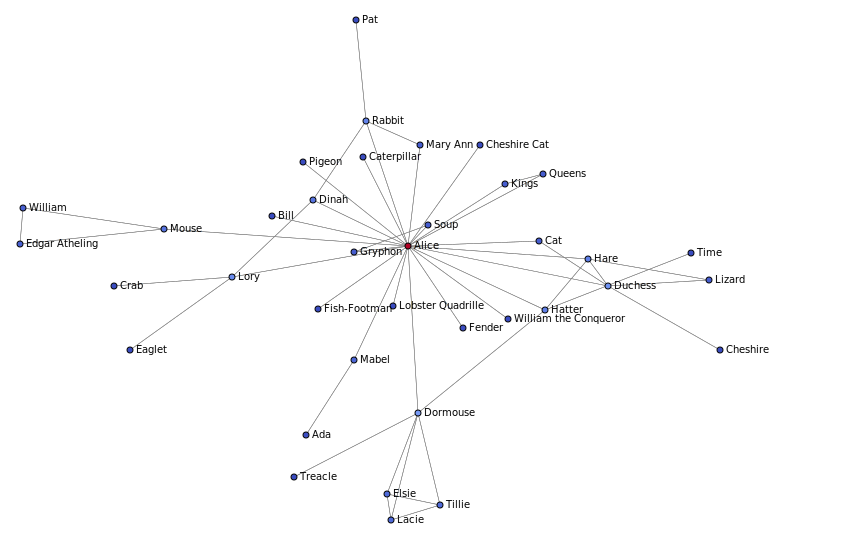

In [12]:
draw_graph(G, show_names=True, node_size=3)

# Network Attack Simulation

Today's post is about offense, not defense. The goal of today's post is going to be to cause maximal disruption to the Alice network in as few steps as possible. I am going to use two approaches, but you are not limited to two. Be creative.

- ## Simulation 1: Iterative Attack
In this simulation, I will remove the four nodes having highest betweenness centrality, but one after the other, sequantially. 1, 2, 3, 4.

- ## Simulation 2: Burst Attack
In this simulation,, I will remove the four nodes having highest betweenness centrlality scores from the original network, in one burst.

- ## Goal: Fun and Educational
I come from cybersecurity, so I think in terms of offense and defense, but this is not limited to computers. I am using the network from Alice in Wonderland. With any network, network science can give insights to enhance both offense and defense. Today, the focus is offense.

# Simulation 1: Iterative Attack

In [13]:
# need for iteration

def get_cent_df(G):
    
    G = G.copy()
    
    cent_df = pd.DataFrame(nx.betweenness_centrality(G), index=[0]).T # cent = centrality

    cent_df.columns = ['betw_cent'] # betweenness centrality
    cent_df.sort_values('betw_cent', inplace=True, ascending=False)
    
    return cent_df

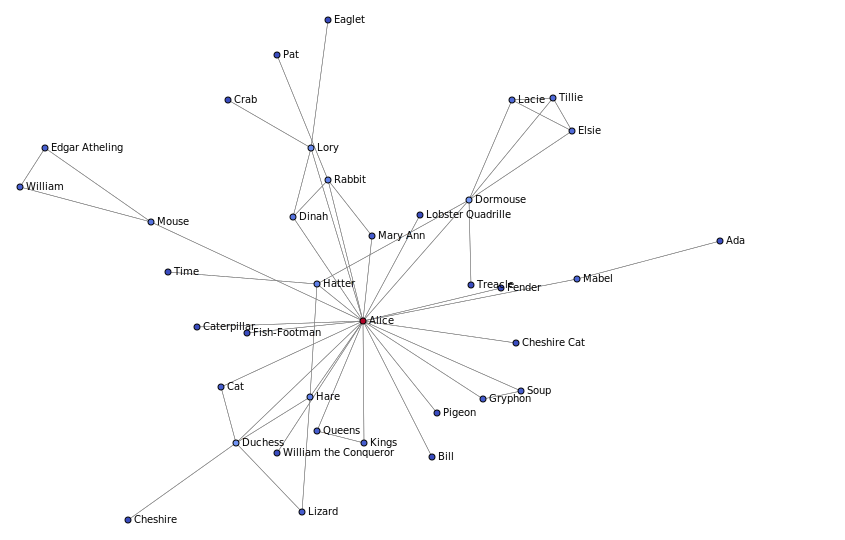

In [14]:
G1 = G.copy() # keep G for use with simulation 2

draw_graph(G1, show_names=True, node_size=3)

## Iteration 1

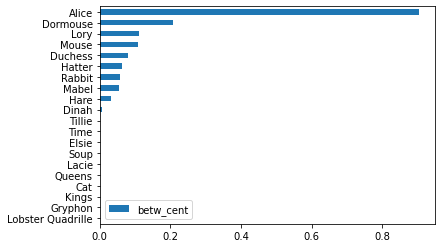

In [15]:
cent_df = get_cent_df(G1)

cent_df[0:20].plot.barh().invert_yaxis()

# because there are so few with betw_cent, I expect the network to be nearly ruined with either approach

In [16]:
# Smash and Draw, Sequentially

# first iteration; drop node

drop_node = cent_df.iloc[0].name
drop_node

'Alice'

In [17]:
G1.remove_node(drop_node)

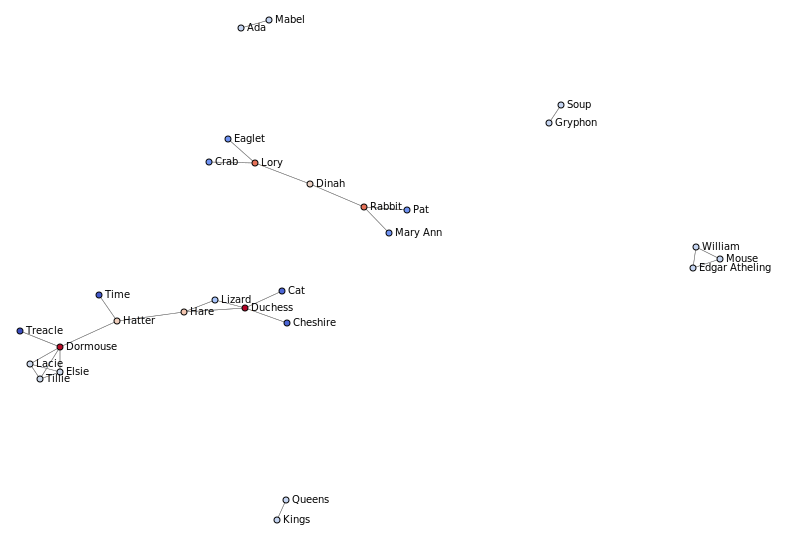

In [18]:
draw_graph(nx.k_core(G1, 1), show_names=True, node_size=3) # removing isolates for clarity

## Iteration 2

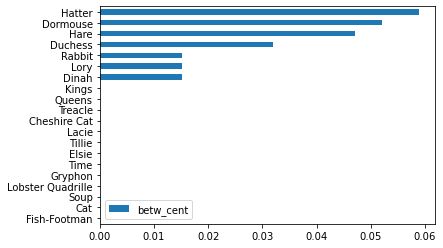

In [19]:
cent_df = get_cent_df(G1)

cent_df[0:20].plot.barh().invert_yaxis()

In [20]:
drop_node = cent_df.iloc[0].name
drop_node

'Hatter'

In [21]:
G1.remove_node(drop_node)

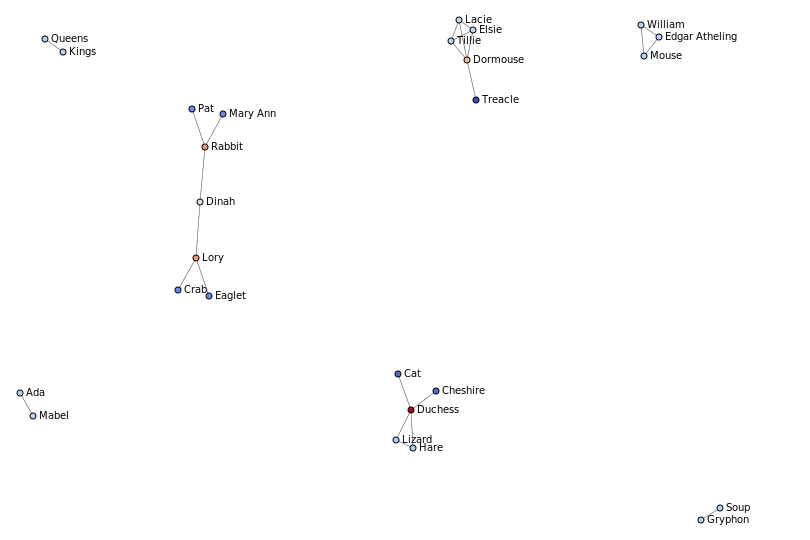

In [22]:
draw_graph(nx.k_core(G1, 1), show_names=True, node_size=3) # removing isolates for clarity

## Iteration 3

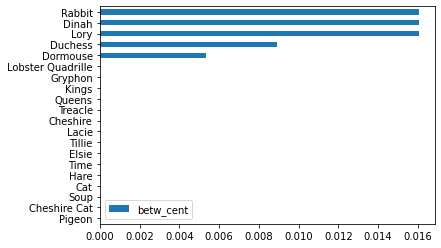

In [23]:
cent_df = get_cent_df(G1)

cent_df[0:20].plot.barh().invert_yaxis()

In [24]:
drop_node = cent_df.iloc[0].name
drop_node

'Rabbit'

In [25]:
G1.remove_node(drop_node)

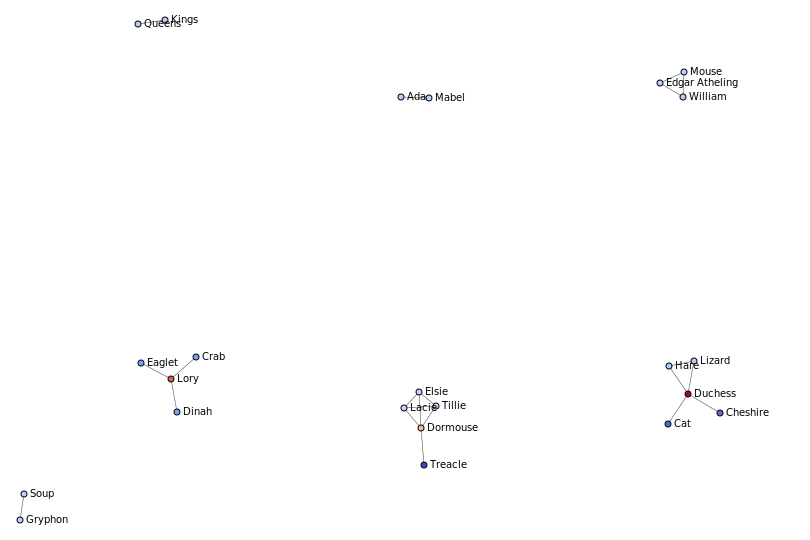

In [26]:
draw_graph(nx.k_core(G1, 1), show_names=True, node_size=3) # removing isolates for clarity

## Iteration 4

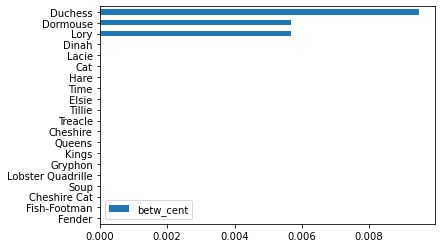

In [27]:
cent_df = get_cent_df(G1)

cent_df[0:20].plot.barh().invert_yaxis()

In [28]:
drop_node = cent_df.iloc[0].name
drop_node

'Duchess'

In [29]:
G1.remove_node(drop_node)

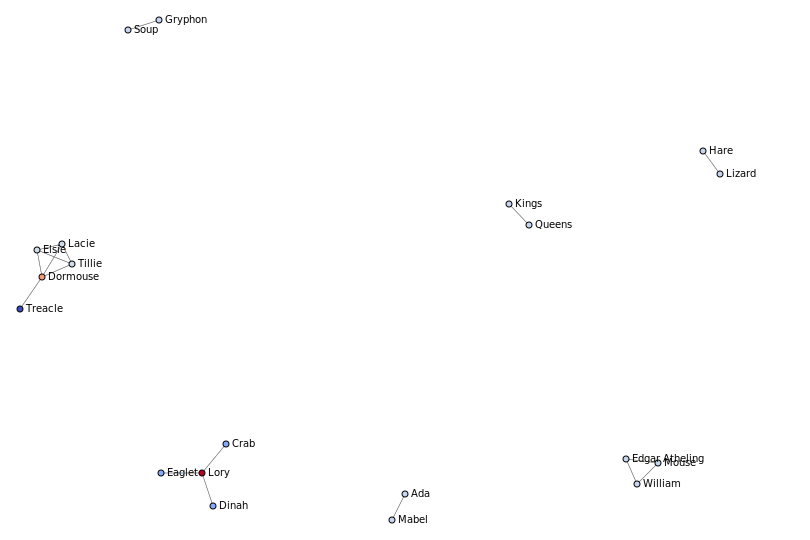

In [30]:
draw_graph(nx.k_core(G1, 1), show_names=True, node_size=3) # removing isolates for clarity

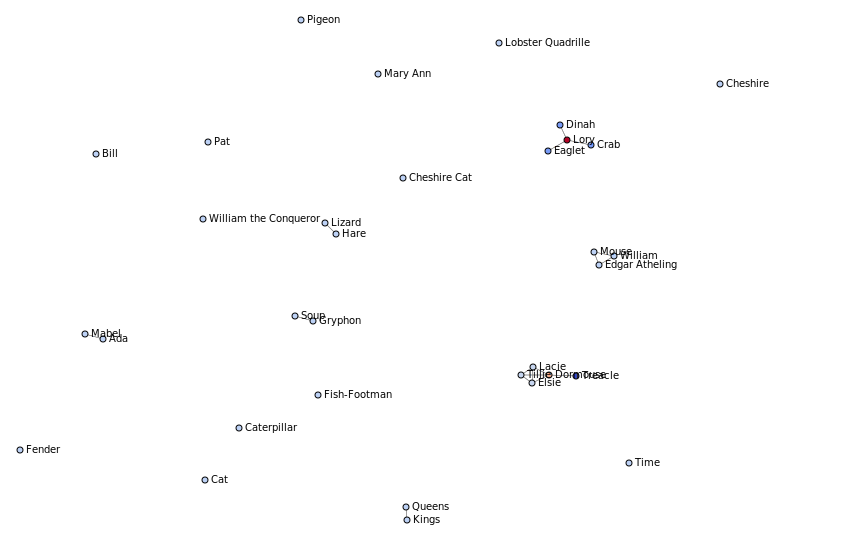

In [31]:
draw_graph(G1, show_names=True, node_size=3) # removing isolates for clarity

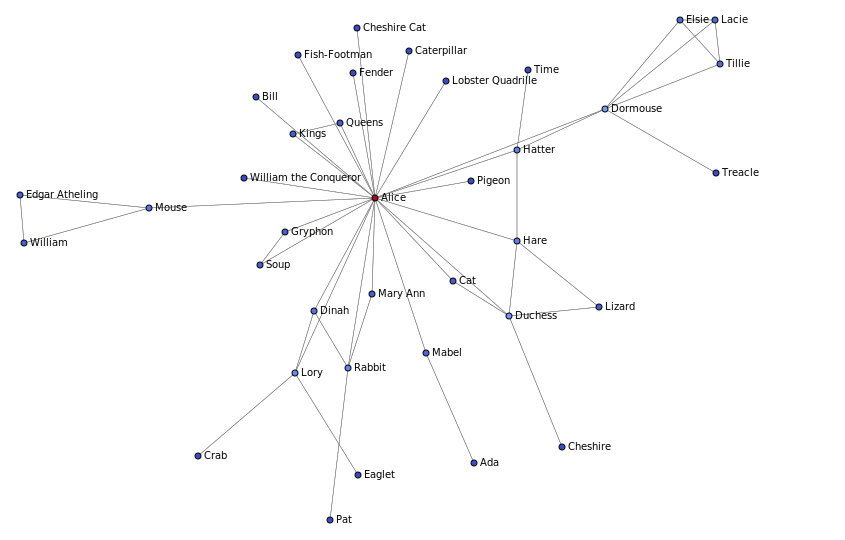

In [32]:
draw_graph(G, show_names=True, node_size=3)

In [33]:
nx.density(G)

0.07507507507507508

In [34]:
nx.density(G1)

0.032196969696969696

In [35]:
print(G)

Graph with 37 nodes and 50 edges


In [36]:
print(G1)

Graph with 33 nodes and 17 edges


In [37]:
components = list(nx.connected_components(G1))

[len(c) for c in components]

[4, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 1, 2, 2, 1]

In [38]:
len(components)

20

In [39]:
np.mean([len(c) for c in components]) # average component size

1.65

# Simulation 2: Burst Attack

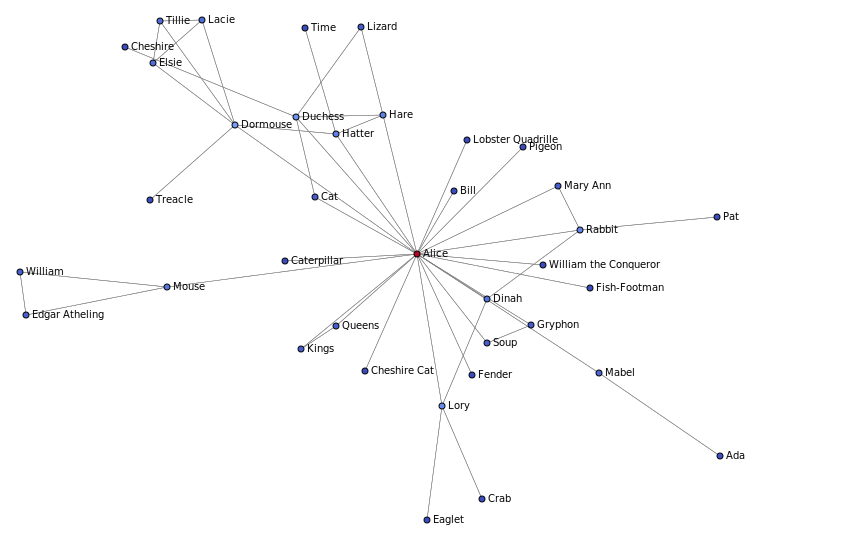

In [40]:
G2 = G.copy() # keep G for use with simulation 2

draw_graph(G2, show_names=True, node_size=3)

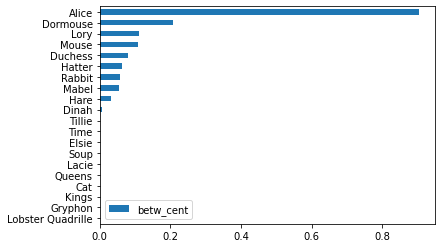

In [41]:
cent_df = get_cent_df(G2)

cent_df[0:20].plot.barh().invert_yaxis()

In [42]:
drop_nodes = list(cent_df[0:4].index)

drop_nodes

['Alice', 'Dormouse', 'Lory', 'Mouse']

In [43]:
G2.remove_nodes_from(drop_nodes)

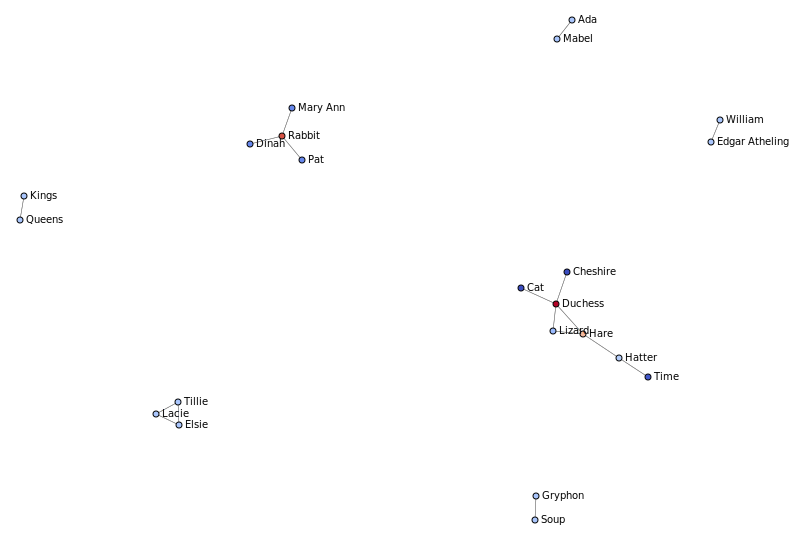

In [44]:
draw_graph(nx.k_core(G2, 1), show_names=True, node_size=3) # removing isolates for clarity

In [45]:
nx.density(G)

0.07507507507507508

In [46]:
nx.density(G2)

0.032196969696969696

In [47]:
print(G)

Graph with 37 nodes and 50 edges


In [48]:
print(G2)

Graph with 33 nodes and 17 edges


In [49]:
components = list(nx.connected_components(G2))

[len(c) for c in components]

[4, 1, 7, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 2, 2, 1]

In [50]:
len(components) # fewer, less disrupted

18

In [51]:
np.mean([len(c) for c in components]) # average component size

1.8333333333333333

# Outcome: 

Impact looks nearly identical. Both approaches were catastrophic on the network, disrupting communication between nodes.

However, the first approach was more disruptive, resulting in more and smaller connnected components. The network has been shattered into more pieces using the first approach.